# basic model


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, MaxPooling2D, Concatenate, Add, Conv2D, Subtract, Multiply, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

import os
import numpy as np
import cv2


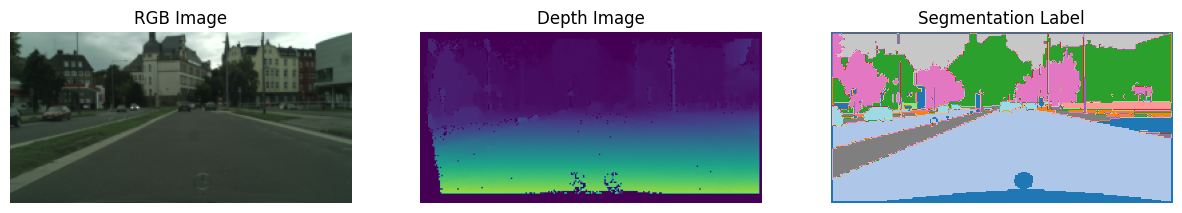

In [16]:
depth_folder = './train/depth'
rgb_folder = './train/image'
segmentation_label_folder = './train/label'

# Get the sorted list of file names to ensure they match by index
depth_files = sorted(os.listdir(depth_folder))
rgb_files = sorted(os.listdir(rgb_folder))
segmentation_label_files = sorted(os.listdir(segmentation_label_folder))

# Make sure each folder has the same number of files
assert len(depth_files) == len(rgb_files) == len(segmentation_label_files), "Mismatch in file counts across folders."

# Load the data
data = []
for i in range(len(depth_files)):
    depth_path = os.path.join(depth_folder, depth_files[i])
    rgb_path = os.path.join(rgb_folder, rgb_files[i])
    seg_label_path = os.path.join(segmentation_label_folder, segmentation_label_files[i])

    # Load each .npy file
    depth_img = np.load(depth_path)
    rgb_img = np.load(rgb_path)
    seg_label = np.load(seg_label_path)

    # Append a tuple of the loaded arrays
    data.append((depth_img, rgb_img, seg_label))

import matplotlib.pyplot as plt

# Retrieve the first image's data
depth_img, rgb_img, seg_label = data[1]

# Plot each component
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot RGB image
axes[0].imshow(rgb_img)
axes[0].set_title('RGB Image')
axes[0].axis('off')

# Plot Depth image
# Assuming depth data is a single channel, use a colormap to enhance visualization
axes[1].imshow(depth_img, cmap='viridis')
axes[1].set_title('Depth Image')
axes[1].axis('off')

# Plot Segmentation Label
# Assuming segmentation labels are integers, use a color map for clear separation
axes[2].imshow(seg_label, cmap='tab20')
axes[2].set_title('Segmentation Label')
axes[2].axis('off')

plt.show()

In [17]:
seg_label = data[0][2]

# Get unique classes in the segmentation label
unique_classes = np.unique(seg_label)
num_classes = len(unique_classes)
print(f"Unique classes in segmentation label: {unique_classes}")
print(f"Number of segmentation classes: {num_classes}")
print(to_categorical(seg_label).shape)

Unique classes in segmentation label: [-1.  0.  1.  2.  5.  7.  8.  9. 10. 11. 12. 13. 18.]
Number of segmentation classes: 13
(128, 256, 19)


In [18]:
# Paths to the dataset
rgb_dir = './train/image'
label_dir = './train/label'
depth_dir = './train/depth'

# Parameters
rgb_shape = (128, 256, 3)
input_shape = (128, 256, 3)
num_classes = 20
batch_size = 35


class NPYDataGenerator(Sequence):
    def __init__(self, rgb_dir, label_dir, depth_dir, batch_size=8, image_size=(128, 256), num_classes=20, shuffle=True):
        self.rgb_dir = rgb_dir
        self.label_dir = label_dir
        self.depth_dir = depth_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.file_indices = sorted([int(f.split('.')[0]) for f in os.listdir(rgb_dir)])
        self.on_epoch_end()

    def __len__(self):
        return len(self.file_indices) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.file_indices[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_indices)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_indices)

    def __data_generation(self, batch_indices):
        # Initialize empty arrays for RGB and labels
        X = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, *self.image_size, 1), dtype=np.int32) # One hot encoded y with 19 channels one for each segmentation class

        for i, idx in enumerate(batch_indices):
            rgb_path = os.path.join(self.rgb_dir, f"{idx}.npy")
            label_path = os.path.join(self.label_dir, f"{idx}.npy")
            
            # Load and normalize RGB image
            X[i] = np.load(rgb_path).astype(np.float32) / 255.0      
                  
            
            # Load label and add 1 to shift labels from -1 (background) to 0 (background) and 1-19 for classes
            y[i] = np.load(label_path).astype(np.int32).reshape((*self.image_size, 1)) + 1
        
        y_one_hot = to_categorical(y, num_classes=num_classes)

        return X, y_one_hot

# Initialize the data generator
train_generator = NPYDataGenerator(rgb_dir, label_dir, depth_dir, batch_size=batch_size, image_size=rgb_shape[:2], num_classes=num_classes)

# Paths to the validation dataset
val_rgb_dir = './val/image'
val_label_dir = './val/label'
val_depth_dir = './val/depth'

# Initialize the data generator for validation
val_generator = NPYDataGenerator(val_rgb_dir, val_label_dir, val_depth_dir, batch_size=batch_size, image_size=rgb_shape[:2], num_classes=num_classes)

# Paths to the test dataset
test_rgb_dir = './test/image'
test_label_dir = './test/label'  # Optional, only if you want to evaluate against ground truth
test_depth_dir = './test/depth'

# Initialize the test data generator
test_generator = NPYDataGenerator(
    rgb_dir=test_rgb_dir,
    label_dir=test_label_dir,
    depth_dir=test_depth_dir,
    batch_size=batch_size,
    image_size=rgb_shape[:2],
    num_classes=num_classes,
    shuffle=False  # Shuffling disabled for consistency during testing
)

In [ ]:
def unet(input_shape=(128, 128, 3), num_classes=20):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(512, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(256, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(128, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(64, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(64, 3, activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(32, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(32, 3, activation='relu', padding='same')(c9)

    # Segmentation output
    segmentation_output = Conv2D(num_classes, 1, activation='softmax', name='segmentation_mask')(c9)

    model = Model(inputs=inputs, outputs=segmentation_output)
    return model

unet_model = unet(input_shape, num_classes)
unet_model.compile(
    optimizer=Adam(),
    loss={
        'segmentation_mask': CategoricalCrossentropy(from_logits=False),
    },
    metrics={'segmentation_mask': 'accuracy'}
)


unet_history = unet_model.fit(train_generator, validation_data=val_generator, epochs=10)

C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.2834 - loss: 2.5357 - val_accuracy: 0.3340 - val_loss: 1.9461


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


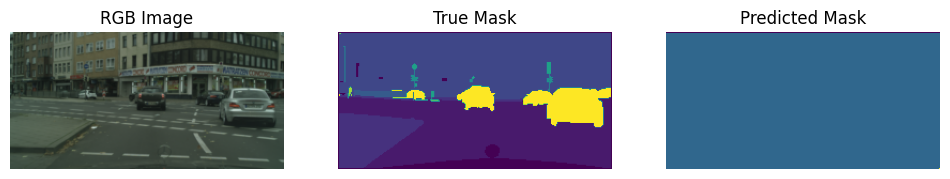

In [26]:
# Paths to the test dataset
test_rgb_dir = './test/image'
test_label_dir = './test/label'  # Optional, only if you want to evaluate against ground truth
test_depth_dir = './test/depth'

# Initialize the test data generator
test_generator = NPYDataGenerator(
    rgb_dir=test_rgb_dir,
    label_dir=test_label_dir,
    depth_dir=test_depth_dir,
    batch_size=batch_size,
    image_size=rgb_shape[:2],
    num_classes=num_classes,
    shuffle=False  # Shuffling disabled for consistency during testing
)

# Load one batch from the validation generator
val_images, val_labels = test_generator[0]

# Select the first image in the batch
sample_image = val_images[0]  # This includes RGB, depth, and one-hot label channels
true_label = val_labels[0]  # Ground truth segmentation mask for the main output

# Predict using the model
predictions = unet_model.predict(np.expand_dims(sample_image, axis=0))

# Extract predicted segmentation mask
predicted_mask = np.argmax(predictions[0], axis=-1)  # main_segmentation_out is the first output in the list
true_mask = np.argmax(true_label, axis=-1)

# Plot the RGB image, true mask, and predicted mask
plt.figure(figsize=(12, 4))

# Display RGB image
plt.subplot(1, 3, 1)
plt.imshow(sample_image[:, :, :3]*255)  # Only take RGB channels
plt.title("RGB Image")
plt.axis('off')

# Display ground truth segmentation mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='viridis')
plt.title("True Mask")
plt.axis('off')

# Display predicted segmentation mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [25]:
predictions[0].shape

(128, 256, 20)

In [27]:
predicted_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 3]], dtype=int64)